# How does cinema view the world?

This project will explore how cities and countries are depicted in cinema.

We will explore this topic from multiple aspects.

Contents:

0. [Data preprocessing](#data-preprocessing)
1. [General analysis by city/country](#general-analysis-by-location)
2. [Genre distributions & Bias](#genre-distributions--bias)
3. [Exploring how different countries view each other](#exploring-how-different-countries-view-each-other)
4. [Exploring how locations changed their view in time](#exploring-how-locations-changed-their-view-in-time)
5. [Character depiction and stereotypes](#character-depiction-and-stereotypes)

## Data preprocessing

### Imports

Here we import the required libraries and helper functions we will need for the analysis.

In [43]:
import os

import pandas as pd
import numpy as np

# We use google maps to get the coordinates of the cities/countries.
import googlemaps

# We use our own helper functions to load the data and get an embedding.
from helpers import load_data, get_embedding

# To track progress we use the tqdm package.
import tqdm

# To load our generated movie analysis we will use the json package.
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# We plot this using seaborn.
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# We hide warnings to make the notebook a bit cleaner.
import warnings
warnings.filterwarnings("ignore")

### Data loading

For the project we are using the [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas/) which contains plot summaries of 42,306 movies. The dataset also contains a number of metadata information about the movie and the actors.

We will use the following files from the dataset:
- `plot_summaries.txt` - which contains the plot summaries.
- `character.metadata.tsv` - which contains information about the characters and actors that play in a movie.
- `movie.metadata.tsv` - which contains information about movies.


As our project explores how *cinema views the world* as our main tool we have decided to analyze how the location of a movie affects the story, characters and what bias can be found.

#### Location information
The dataset does not provide the plot location to us and as such we have extracted location information using the newly released [JSON ChatGPT API](https://platform.openai.com/docs/guides/text-generation/json-mode).

With the use of the OpenAI API we have extracted the following information for each movie summary:

Example output of the movie ***Pest from the West***
```json
{
   "cities": [
      "Mexico City"
   ],
   "countries": [
      "Mexico"
   ],
   "characters": {
      "Keaton": {
         "nationality": "USA",
         "alignment": "good"
      }
   }
}
```

This data resides in the `movie_analysis.json` file. The code that helped us generate these results resides in `calculate-locations.ipynb`.

#### Embeddings
We have also computed semantic embeddings of all summaries in order to be able to get similarity metrics between movies or from a term to a movie. To calculate these embeddings we have used the [OpenAI Embeddings API](https://platform.openai.com/docs/guides/embeddings). Each embedding vector is `1536` dimensional.

The embeddings are stored in the `embeddings.npy` file. The code that helped us generate these results resides in `calculate-embeddings.ipynb`.


#### TMDB Dataset

We plan on using the [TMDB databaset](https://www.themoviedb.org) in order to get good user scores for movies. This dataset provides us with an easy to use python library and as such there will be no data problems.

In [44]:
DATA_PATH = 'data/'

# We load the data using our helper function.
loaded_data = load_data(DATA_PATH)

# We initialize the google maps client using our API key.
gmaps = googlemaps.Client(key=os.environ['GOOGLE_MAPS_API_KEY'])

# We extract the variables from the loaded data.
character_metadata = loaded_data['character_metadata'] # The metadata of the characters.
movie_metadata = loaded_data['movie_metadata'] # The metadata of the movies.
plot_summaries = loaded_data['plot_summaries'] # The plot summaries of the movies.
embeddings = loaded_data['embeddings'] # The embeddings of the movies as a numpy array.
combined_plot_summaries = loaded_data['combined_plot_summaries'] # The movie summaries combined with their embeddings.
city_country_analysis = loaded_data['city_country_analysis'] # The analysis of the cities and countries.
cities = city_country_analysis['cities'] # A list of all the cities.
countries = city_country_analysis['countries'] # A list of all the countries.
cities_movies = city_country_analysis['cities_movies'] # A dictionary mapping cities to movies.
countries_movies = city_country_analysis['countries_movies'] # A dictionary mapping countries to movies.
embeddings_of_movies_in_cities = city_country_analysis['embeddings_of_movies_in_cities'] # A dictionary mapping cities to embeddings of movies.
embeddings_of_movies_in_countries = city_country_analysis['embeddings_of_movies_in_countries'] # A dictionary mapping countries to embeddings of movies.

## General analysis by location

#### Magnitude

Before we start the analysis we should first see how many movies we have that actually contain location information. As the action for a movie can be left unspecified or the location can be fictitious.

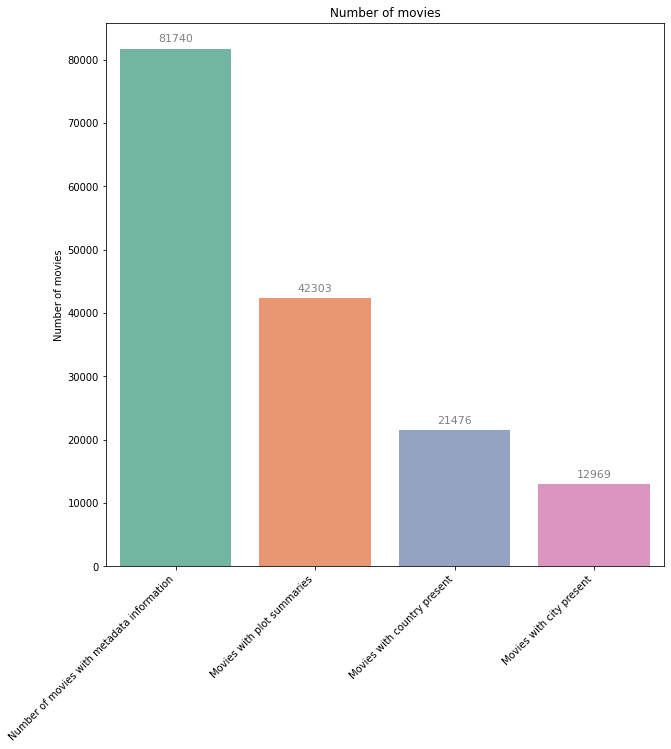

In [45]:
# We get the initial number of movies in movies_metadata.
initial_number_of_movies = len(movie_metadata)

# We get the number of movies in plot_summaries.
initial_number_of_movies_in_plot_summaries = len(plot_summaries)

# We get the number of movies in cities_movies.
initial_number_of_movies_in_cities = [cities_movies[city] for city in cities_movies]
# We flatten the list.
initial_number_of_movies_in_cities = [movie for movies in initial_number_of_movies_in_cities for movie in movies]

# We get the number of movies in countries_movies.
initial_number_of_movies_in_countries = [countries_movies[country] for country in countries_movies]
# We flatten the list.
initial_number_of_movies_in_countries = [movie for movies in initial_number_of_movies_in_countries for movie in movies]

# We get the number for cities
initial_number_of_movies_in_cities = len(set(initial_number_of_movies_in_cities))

# We get the number for countries
initial_number_of_movies_in_countries = len(set(initial_number_of_movies_in_countries))

# We create a figure.
fig = plt.figure(figsize=(10, 10))

x = ['Number of movies with metadata information', 'Movies with plot summaries', 'Movies with city present', 'Movies with country present']
y = [initial_number_of_movies, initial_number_of_movies_in_plot_summaries, initial_number_of_movies_in_cities, initial_number_of_movies_in_countries]
# ordered by the number of movies
ax = sns.barplot(x= [x for _,x in reversed(sorted(zip(y,x))) ],
                 y= list(reversed(sorted(y))),
                 palette= sns.color_palette("Set2"))


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show precise number on top of bar
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
# We set the title.
ax.set_title('Number of movies')

# Set the y-axis label
ax.set_ylabel('Number of movies')

plt.show()

We seem have been able to find over 21 thousand movies with location present, this is a sufficient sample size for our experiments and more than half of the available plot summaries to begin.

#### Distribution of movies on the globe

In this subchapter we will explore the distribution of movie settings by location. We will see if Europe or the USA leads as expected and by how much.

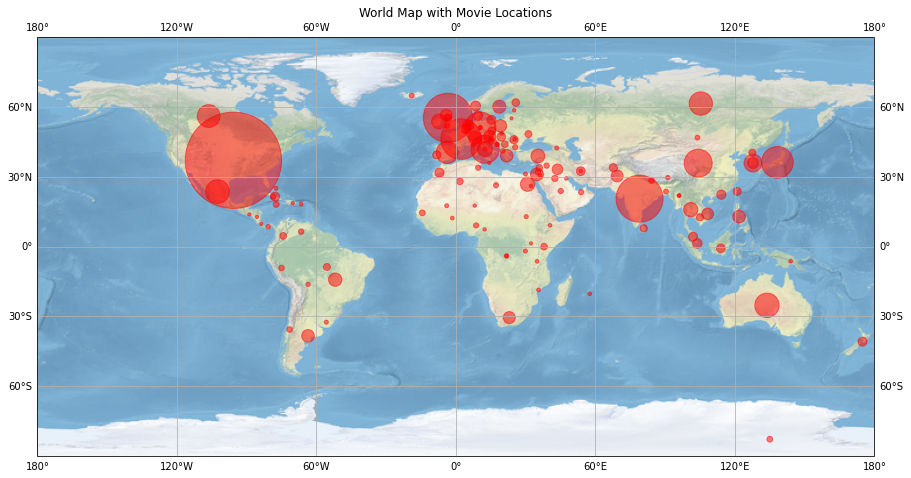

In [46]:
import cartopy.crs as ccrs

# Initialize lists to store latitudes, longitudes, and sizes
lats, lngs, sizes = [], [], []

# Loop over the countries and geocode them
for country, movies in countries_movies.items():
    geocode_result = gmaps.geocode(country)
    if geocode_result:
        lat = geocode_result[0]["geometry"]["location"]["lat"]
        lng = geocode_result[0]["geometry"]["location"]["lng"]
        lats.append(lat)
        lngs.append(lng)
        sizes.append(len(movies))

# Plotting
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add the map
ax.stock_img()

# Add the scatter plot on top of the map
# Size of each point is proportional to the number of movies
ax.scatter(lngs, lats, s=sizes, alpha=0.5, color='red', transform=ccrs.Geodetic())

# Add gridlines and labels
ax.gridlines(draw_labels=True)

plt.title('World Map with Movie Locations')
plt.show()


We can easily observe from the plot that most movies are either in the USA, Europe or India. Africa being very underrepresented overall. Even so we have a decent number of movies that are from almost all major countries.

#### Most popular cities

City popularity is one of the even more uneven representations in cinema. We will show that some cities have orders of magintude more movies written about them than others.

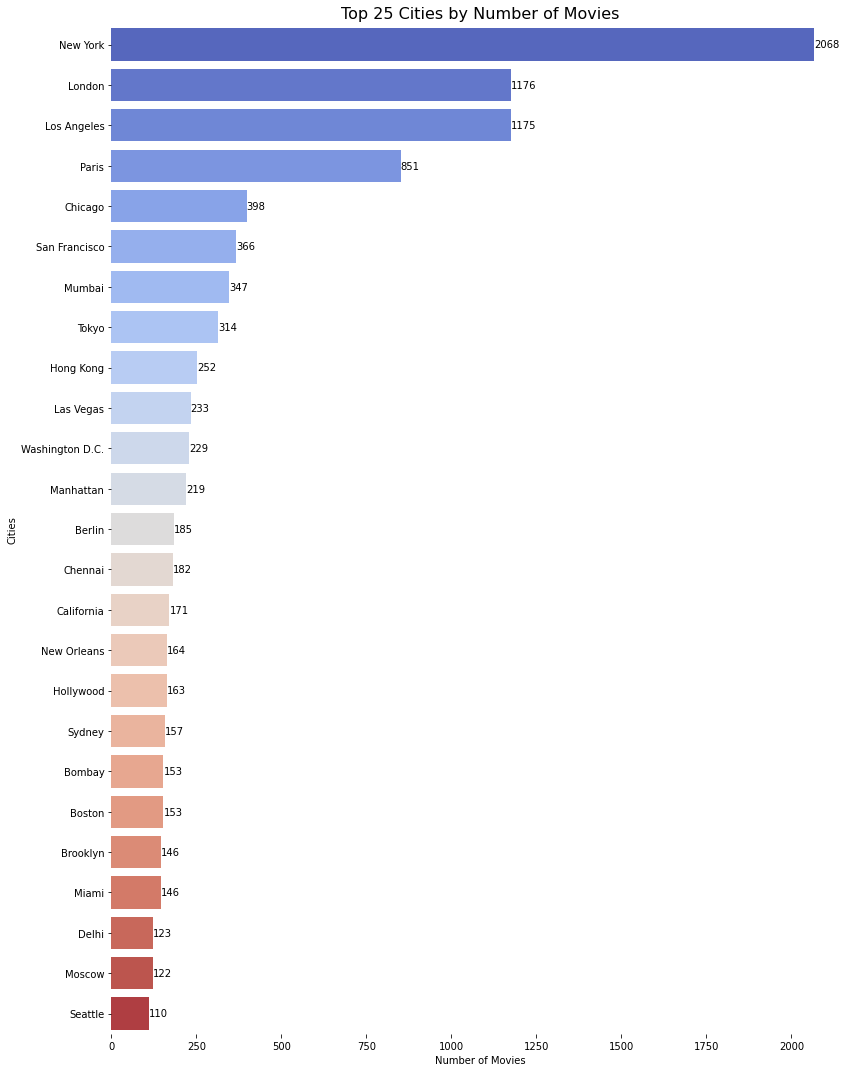

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

cities_movies_counts = {city: len(movies) for city, movies in cities_movies.items()}

# Sort the cities by the number of movies and get the top 25
sorted_city_data = sorted(cities_movies_counts.items(), key=lambda x: x[1], reverse=True)[:25]
top_cities, top_movie_counts = zip(*sorted_city_data)

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 15))
sns.barplot(x=list(top_movie_counts), y=list(top_cities), palette=sns.color_palette("coolwarm", n_colors=len(top_cities)), ax=ax)

# Set labels and title
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Cities')
ax.set_title('Top 25 Cities by Number of Movies', fontsize=16)

# Show precise number on top of each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.3, p.get_y() + p.get_height() / 2.,
            '%d' % int(width), va='center')

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()


We can observe that a large number of movies take place in a small number of cities with ***New York***, ***London***, ***Los Angeles*** and ***Paris*** being in the lead with a big margin.

#### Visualization via cluster analysis

We will now explore using the `embeddings` we generated if movies in a certain country/city usually cluster together.

In [4]:
# We calculate the T-SNE embedding of all movies
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(embeddings)

In [10]:
# We hardcode some countries to check.
countries_to_check = ['Germany', 'Vietnam', 'South Korea', 'India', 'North Korea', 'France']

# We get all movies in these countries.
movies_in_countries_to_check = [countries_movies[country] for country in countries_to_check]

# We get the embeddings of these movies from T-SNE by using the indices in combined_plot_summaries.
tsne_movies_in_countries_to_check = [tsne_obj[combined_plot_summaries[combined_plot_summaries['Wikipedia movie ID'].isin(movies)].index] for movies in movies_in_countries_to_check]

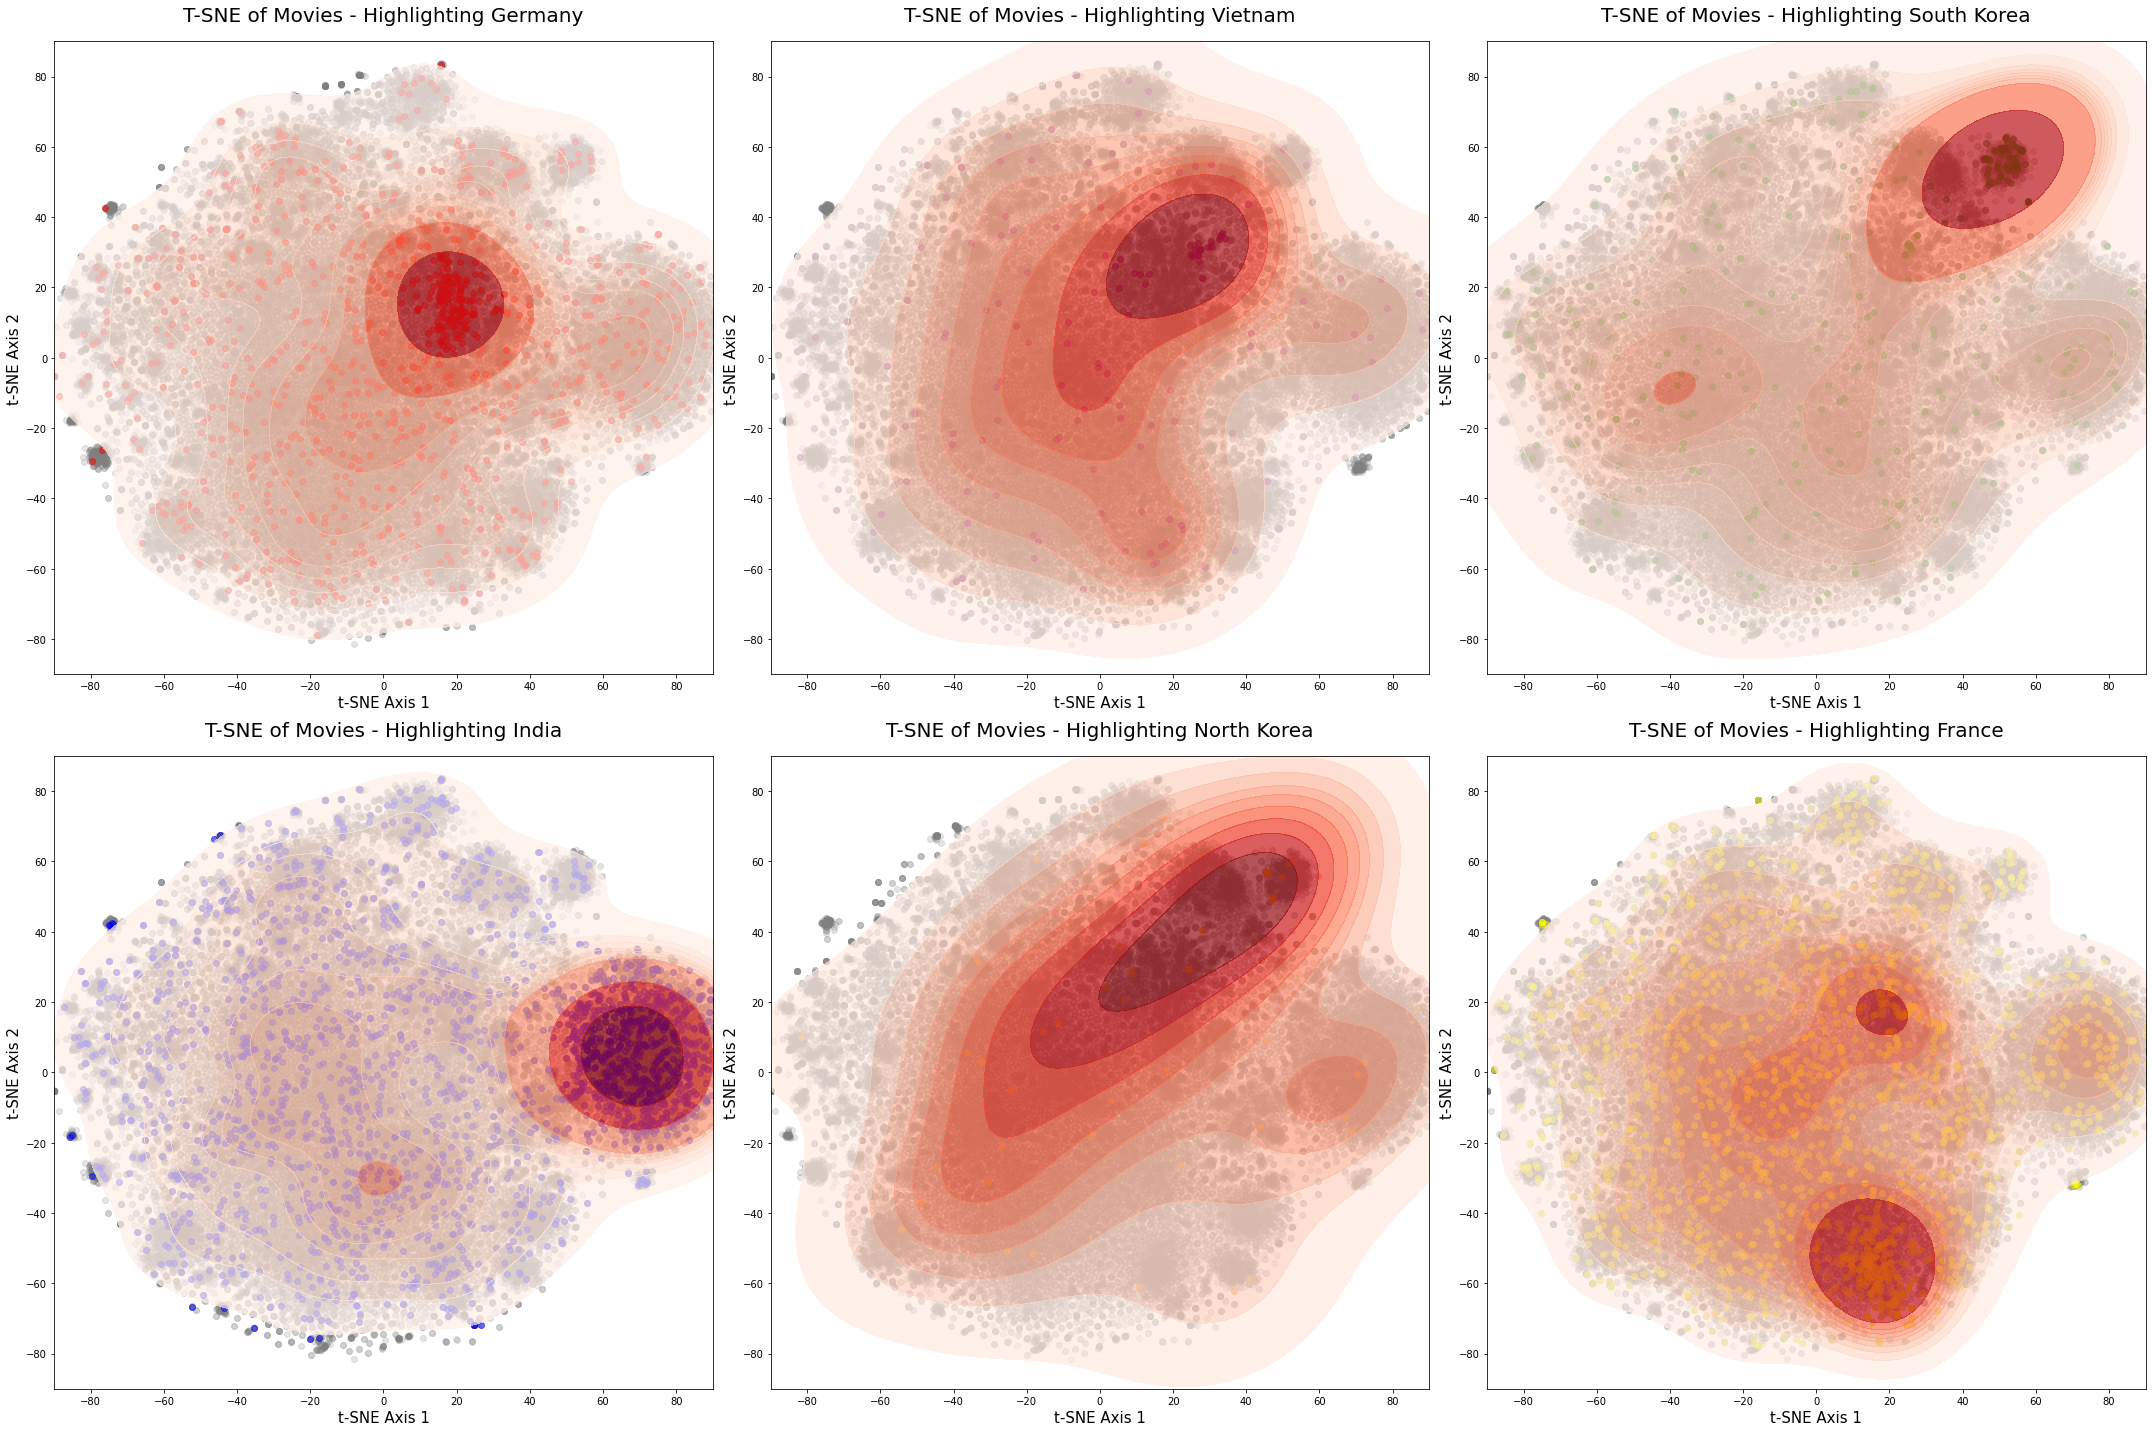

In [12]:
# Colors for each country
colors = ['red', 'purple', 'green', 'blue', 'orange', 'yellow']

# Determine the number of rows and columns for the subplots
n_countries = len(countries_to_check)
n_cols = 3
n_rows = (n_countries + n_cols - 1) // n_cols

# Create a figure with multiple axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, country in enumerate(countries_to_check):
    ax = axes[i]

    # Highlight the movies from the specific country
    country_movies = tsne_movies_in_countries_to_check[i]
    x_country, y_country = [movie[0] for movie in country_movies], [movie[1] for movie in country_movies]

    # Scatter plot for all movies
    ax.scatter(tsne_obj[:, 0], tsne_obj[:, 1], color='gray', alpha=0.2)

    # Scatter plot for the highlighted movies
    ax.scatter(x_country, y_country, alpha=0.5, color=colors[i])

    # KDE plot for the highlighted movies
    sns.kdeplot(x=x_country, y=y_country, ax=ax, cmap='Reds', shade=True,  alpha=0.7)
    # Set titles and labels
    ax.set_title(f'T-SNE of Movies - Highlighting {country}', pad=20, fontsize=20)
    ax.set_xlabel('t-SNE Axis 1', fontsize=15)
    ax.set_ylabel('t-SNE Axis 2', fontsize=15)
    
    # Set x adn y limits
    ax.set_xlim([-90, 90])
    ax.set_ylim([-90, 90])
    

# Adjust layout
plt.tight_layout()
plt.show()


We can clearly observe different and distinct clusters for movies from different countries. Germany and India show one of the stronger clusters.

#### Interpretting the clusters

We will now explain each of the countries cluster. We will do this by using our embeddings once again to compute the similarity to a number of different words.

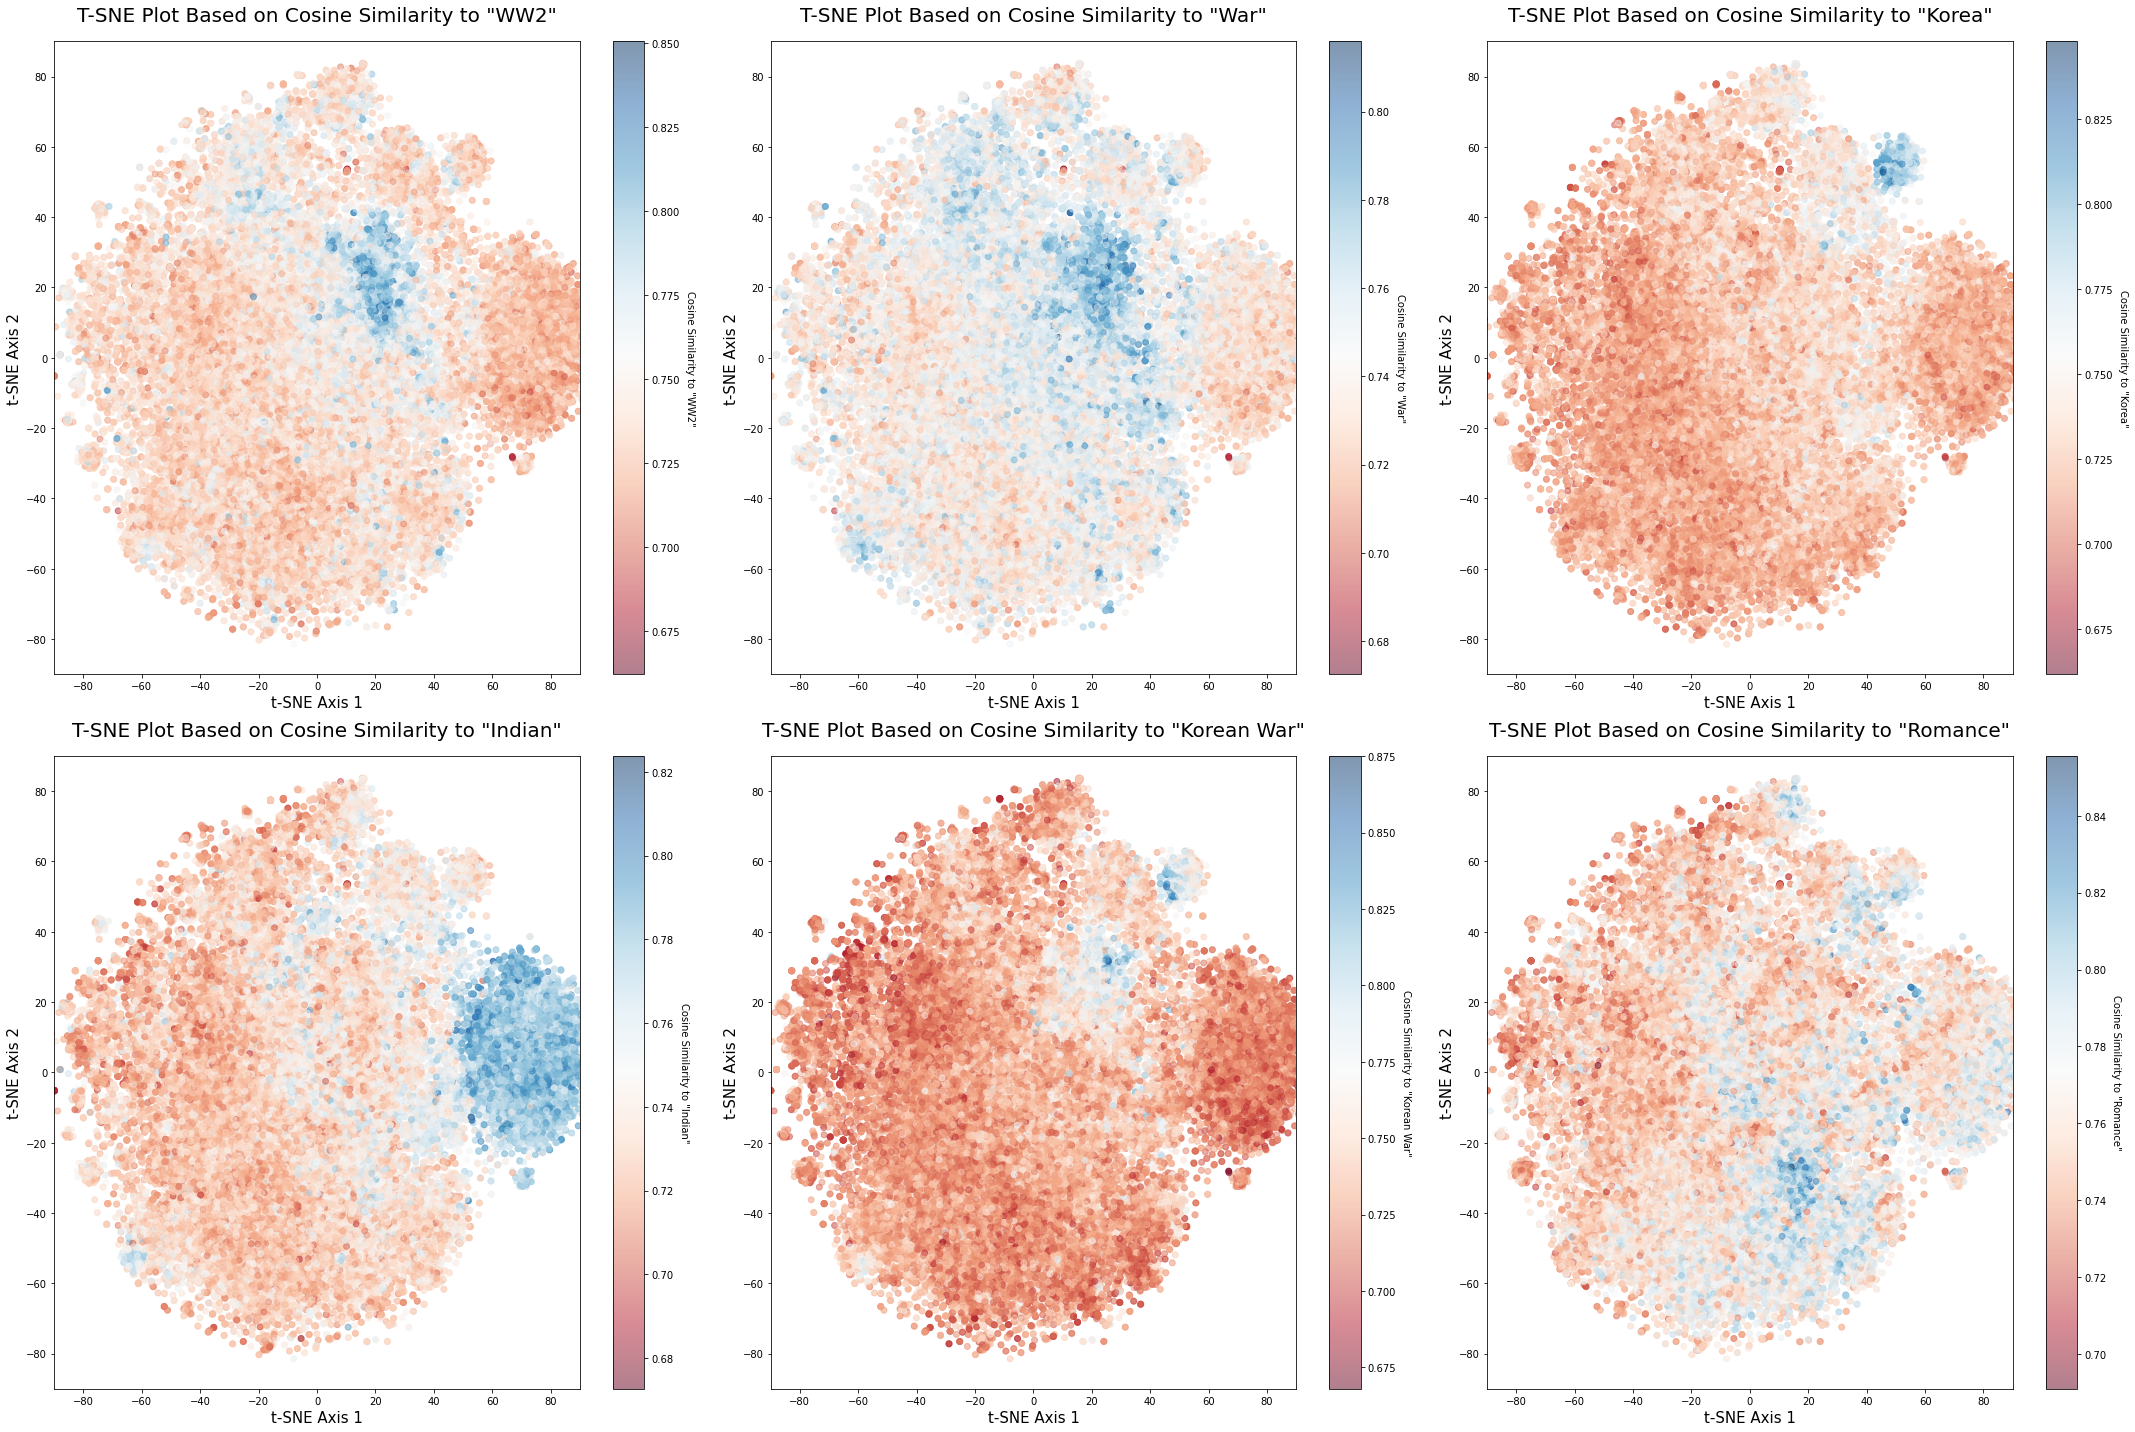

In [38]:
# Define search terms
search_terms = ["WW2", "War", "Korea", "Indian", "Korean War", "Romance"]

# Calculate cosine similarities for each search term
cosine_similarities_dict = {}
for term in search_terms:
    search_embedding = get_embedding(term)
    cosine_similarities_dict[term] = np.dot(embeddings, search_embedding)

# Determine the number of rows and columns for the subplots
n_terms = len(search_terms)
n_cols = 3
n_rows = (n_terms + n_cols - 1) // n_cols

# Create a figure with multiple axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create a scatter plot for each search term
for i, term in enumerate(search_terms):
    ax = axes[i]

    # Create a scatter plot using the cosine similarity for color
    scatter = ax.scatter(tsne_obj[:, 0], tsne_obj[:, 1], c=cosine_similarities_dict[term], cmap='RdBu', alpha=0.5)

    # Adding a color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(f'Cosine Similarity to "{term}"', rotation=270, labelpad=15)

    # Set titles and labels
    ax.set_title(f'T-SNE Plot Based on Cosine Similarity to "{term}"', pad=20, fontsize=20)
    ax.set_xlabel('t-SNE Axis 1', fontsize=15)
    ax.set_ylabel('t-SNE Axis 2', fontsize=15)
    
    # Set x and y limits
    ax.set_xlim([-90, 90])
    ax.set_ylim([-90, 90])

# Adjust layout
plt.tight_layout()
plt.show()


We can make a number of observations:
- The ***German*** cluster matches almost perfectly with the WW2 cluster which makes sense.
- The ***Vietnam*** cluster matches closely with the War cluster.
- The ***South Korean*** cluster depicts Korean movies, no surprise here.
- The ***Indian*** cluster is one of the biggest and most separate clusters and depicts general themes that appear in Indian culture.
- The ***North Korean*** cluster is interesting as it seems to be a combination of both War and Korean which would make sense and we interpreted it as it being depicted mostly in movies about the Korean War.
- The ***France*** cluster is close to the Romance cluster. We will show this relation to be stronger in subsequent chapters but we can already observe a bias.

We can conclude that countries depicting certain countries are usually similar in plot and we will enforce and explore this further in the rest of the chapters.

## Genre distributions & Bias

## Exploring how different countries view each other

## Exploring how locations changed their view in time

## Character depiction and stereotypes